In [1]:
### Prepare module structure ###

import sys
sys.path.append('../')

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


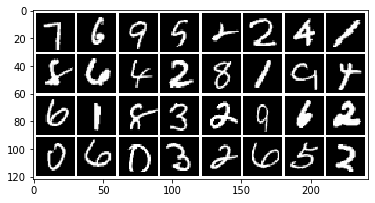

torch.Size([32, 1, 28, 28])


In [4]:
### LOAD DATA ###
dataset = 'mnist'
dataloader, imsize = load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
plot_grid(sample)
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [5]:
def poisson_noise(magn, device, alpha=1):
    intens = magn ** 2
    alpha_2 = alpha ** 2
    lmd = intens / alpha_2
    intens_noise = alpha_2 * torch.distributions.poisson.Poisson(lmd).sample()
    magn_noise = torch.sqrt(intens_noise)
    return magn_noise

def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return mags

# Function to compute test images
def test_generator(model, device, testloader, alpha):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        z = torch.randn(*data.shape).to(device)
        data = data.to(device=device)
        magn = poisson_noise(calc_mags(data), device, alpha)
        net_input = torch.cat([z, magn], dim=1)
        ouput = model(net_input)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
    
    return np.concatenate(outputs), np.concatenate(test_images)

In [6]:
### LOAD MODEL ###

latent_dim = 128
hidden_dim = 500

vae = models.SignalVAE(shape=imsize, latent_dim=latent_dim, hidden_dim=hidden_dim)
vae.load_state_dict(torch.load("../cache/models/VAE_MNIST/FC-VAE128Mnist_3.sd"));

Version 4


In [7]:
### Hand Paper (adapted) ###
def vaeopt(sample_magnitudes, vae, device, measurement_fn=calc_mags,
           z_shape=(20, 1, 1), init_x=None, optim_lr=1e-1, max_steps=5000, max_loss=0.0):
    
    vae.to(device)
    vae.eval()
    
    N = sample_magnitudes.shape[0]
    
    if init_x is None:
        z = torch.randn((N, *z_shape), requires_grad=True, device=device)
    else:
        z = vae.encoder(init_x)[0].clone().detach().requires_grad_(True)
        
    optimizer = optim.Adam([z], lr=optim_lr)
    
    losses = []
    last_out = vae.decoder(z)
    
    for i in range(max_steps):
 
        magnitudes = measurement_fn(last_out)
        mse_all = torch.mean((magnitudes - sample_magnitudes) ** 2, dim=tuple(np.arange(len(magnitudes.shape))[1:]))
        loss = torch.sum(mse_all)
        
        if loss < max_loss:
            break
   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        last_out = vae.decoder(z)

        losses.append(loss.detach().cpu().item())
        
    return last_out.detach(), losses, mse_all

Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished
Batch 32/32 finished


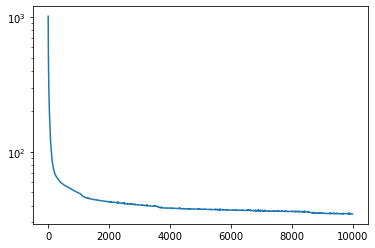

Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished
Batch 32/32 finished


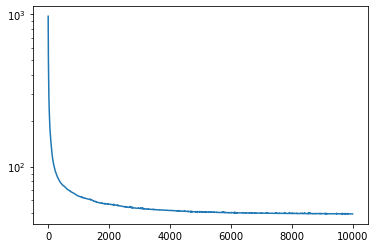

Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished
Batch 32/32 finished


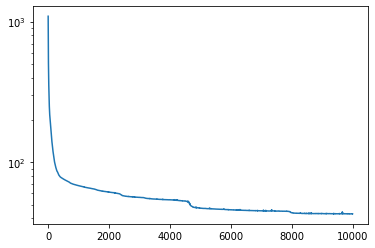

Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished
Batch 32/32 finished


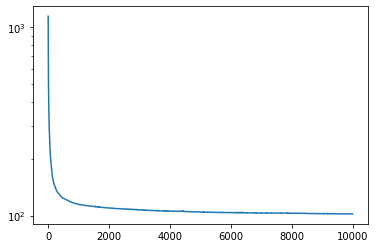

Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished
Batch 32/32 finished


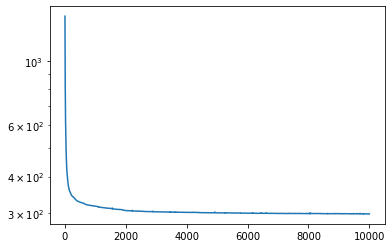

Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished
Batch 32/32 finished


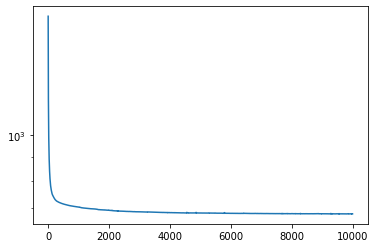

Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished


In [ ]:
### Test one sample Fourier magnitudes random init + multiple restarts ###

alphas = [0.1, 0.3, 1.0, 3.0, 10.0, 25.0, 50.0]

for alpha in alphas:

    num_batches = 32
    batch_size = 32
    max_steps = 10000
    max_loss = 0.0
    optim_lr = 1e-1
    restarts = 3

    ###

    out_original = np.zeros((batch_size * num_batches, *imsize))
    out_results = np.zeros((batch_size * num_batches, *imsize))
    mse_all = np.full((batch_size * num_batches), np.inf)

    for batch_i, batch in enumerate(dataloader['test']):
        test_sample = batch.to(device)
        test_magnitudes = poisson_noise(calc_mags(test_sample), device, alpha)  
        out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()

        for r in range(restarts):
            cur_out_results, cur_loss, cur_mse_all = vaeopt(sample_magnitudes=test_magnitudes, vae=vae, device=device,
                                                            z_shape=(latent_dim, ), optim_lr=optim_lr, max_steps=max_steps,
                                                            max_loss=max_loss)
            cur_out_results = cur_out_results.cpu().numpy()

            for i in range(batch_size):
                mse = mse_all[batch_size * batch_i + i]
                if cur_mse_all[i] < mse:
                    out_results[batch_size * batch_i + i] = cur_out_results[i]
                    mse_all[batch_size * batch_i + i] = cur_mse_all[i]

        print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
        if batch_i + 1 >= num_batches:
            break

    plt.semilogy(cur_loss)
    plt.show()
    
    
    ### CACHE RESULTS ###

    import pickle
    pickle.dump(out_original, open("/home/shared/phase-retrieval/test/VAE_MNIST/randomInit_original_1024_alpha{}.p".format(alpha), "wb"))
    pickle.dump(out_results, open("/home/shared/phase-retrieval/test/VAE_MNIST/randomInit_1024_alpha{}.p".format(alpha), "wb"))

In [15]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/VAE_MNIST/randomInit_original_1024_alpha{}.p".format(alpha), "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/VAE_MNIST/randomInit_1024_alpha{}.p".format(alpha), "wb"))

In [10]:
### LOAD RESULTS ###
import pickle

alpha = 0.3

out_original = pickle.load(open("/home/shared/phase-retrieval/test/VAE_MNIST/randomInit_original_1024_alpha{}.p".format(alpha), "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/VAE_MNIST/randomInit_1024_alpha{}.p".format(alpha), "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


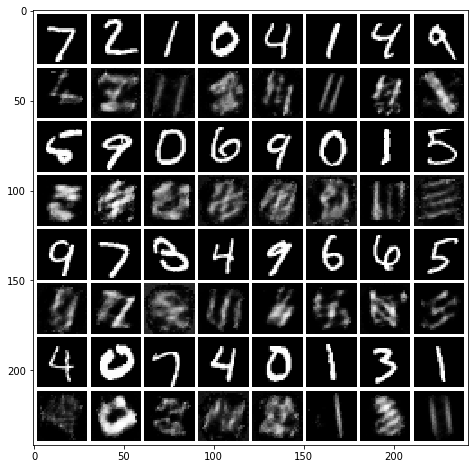

Registered:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


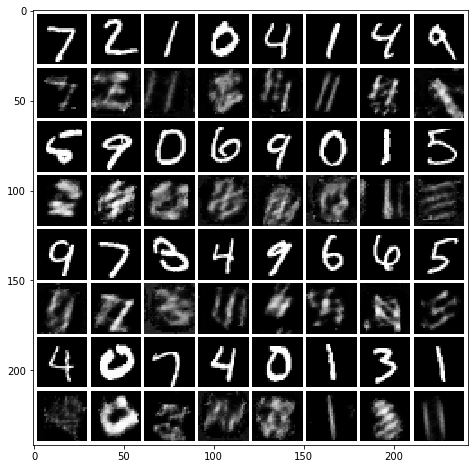

In [30]:
# Benchmark results

print("Output under minimized magnitude distance:")

to_plot = np.stack([out_original[:32].reshape(4, 8, 28, 28), 
                    out_results[:32].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)         
plot_grid(to_plot, figsize=(8, 8),
          file="../out/vae/mnist/{0}{1}.png".format('randomInit_1024_alpha{}_'.format(alpha), time.strftime("%Y%m%d_%H%M%S")))

print("Registered:")
results_reg = register_croco(out_results[:32], out_original[:32])
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8),
          file="../out/vae/mnist/{0}{1}.png".format('randomInit_1024_alpha{}_reg'.format(alpha), time.strftime("%Y%m%d_%H%M%S")))

In [11]:
benchmark(pred=out_results, true=out_original, check_all=True)

Signal error:
  MSE: 0.08577719686109048, std: 0.046009152075772886
  MAE: 0.11602068183582737, std: 0.05179953586723587
  SSIM: 0.43472205943092346, std: 0.25192265103843337
  Sharpness: 0.04719397802065056, std: 0.051528450938466065
  PhCo-MSE: 0.011391244776916193, std: 0.025417536914286387
  PhCo-MAE: 0.02424460563600059, std: 0.03612965010456634
  PhCo-SSIM: 0.9099860778092183, std: 0.1750718290656266
  CroCo-MSE: 0.009365831733471403, std: 0.019758840252077445
  CroCo-MAE: 0.022129708470697677, std: 0.03064762132668311
  CroCo-SSIM: 0.9186420665285926, std: 0.15417480457540847

Magnitude error:
  MSE Magnitude: 0.4539048717399199, std: 0.7598368229661863

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.08578 | 0.1160 | 0.4347 | 0.04719 | 0.01139 | 0.02424 | 0.9100 | 0.009366 | 0.02213 | 0.9186 | 0.4539 |


## Test Fourier magnitudes random init (1024 samples)

| Nr | alpha | MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 3 | 0.1 | 0.08363 | 0.1134 | 0.4464 | 0.04715 | 0.01112 | 0.02403 | 0.9134 | 0.008927 | 0.02172 | 0.9220 | 0.4475 |
| 3 | 0.3 | 0.08578 | 0.1160 | 0.4347 | 0.04719 | 0.01139 | 0.02424 | 0.9100 | 0.009366 | 0.02213 | 0.9186 | 0.4539 |
| 3 | 1.0 | 0.08452 | 0.1149 | 0.4390 | 0.05050 | 0.01157 | 0.02553 | 0.9060 | 0.009763 | 0.02360 | 0.9138 | 0.5045 |
| 3 | 3.0 | 0.08284 | 0.1161 | 0.4328 | 0.06157 | 0.01168 | 0.03031 | 0.8867 | 0.01007 | 0.02854 | 0.8939 | 0.8302 |
| 3 | 10.0 | 0.07762 | 0.1214 | 0.3796 | 0.1003 | 0.02285 | 0.05791 | 0.7380 | 0.01930 | 0.05367 | 0.7579 | 3.713 |
| 3 | 25.0 | 0.07709 | 0.1365 | 0.2825 | 0.1379 | 0.05751 | 0.1146 | 0.4623 | 0.04028 | 0.09460 | 0.5445 | 11.51 |
| 3 | 50.0 | 0.07807 | 0.1508 | 0.2063 | 0.1550 | 0.08046 | 0.1544 | 0.2851 | 0.05485 | 0.1246 | 0.3906 | 21.98 |